<a href="https://colab.research.google.com/github/yadavrishikesh/Deep-Learning-Slides-Code/blob/main/code/DL_Optim/DL_OptimizationAlgorithm_Classification_LinearSep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification and Optimization Algorithms Comparison

In this notebook, we will:
0. Summary of the learned algorithms
1. Simulate a synthetic binary classification dataset.
2. Implement logistic regression from scratch.
3. Train the model using several optimization algorithms:
   - Gradient Descent (GD)
   - Stochastic Gradient Descent (SGD)
   - Newton-Raphson
   - Adam
4. Compare convergence and final classification performance.

# 0. Recall The Optimization Algorithms
## 0.1. Newton–Raphson Method

Newton–Raphson is a root-finding algorithm that uses both the first and second derivatives.

For optimization of a loss function $L(\boldsymbol{w})$:
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_{k} - \left( \nabla^2 L(\boldsymbol{w}_{k}) \right)^{-1} \nabla L(\boldsymbol{w}_{k}).
$$

**Limitations**
- Requires computing and inverting Hessian (costly).
- Unstable if Hessian is not positive definite.

---

## 0.2. Gradient Descent (GD)

Updates parameters in the direction opposite to the gradient:
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_{k} - \eta \nabla L(\boldsymbol{w}_{k}),
$$

**Limitations**
- Needs full dataset per update.
- Sensitive to step size.
- Slow for large datasets.

---

## 0.3. Batch Gradient Descent

Uses entire dataset to compute gradient.

**Pros**
- Stable convergence.

**Cons**
- Very slow for large datasets.

---

## 0.4. Stochastic Gradient Descent (SGD)

Uses one random sample per update:
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_{k} - \eta \nabla L(\boldsymbol{w}_{k}; x_i).
$$

**Pros**
- Fast updates.
- Can escape flat/shallow minima.

**Cons**
- Noisy → fluctuates near minimum.

---

## 0.5. Mini-Batch Gradient Descent

Uses a batch of size $m$:
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_{k} - \eta \frac{1}{m} \sum_{i=1}^{m} \nabla L(\boldsymbol{w}_{k}; x_i).
$$

**Pros**
- Efficient and stable.
- Works well with GPUs.
- Standard in deep learning.

---

## 0.6. Gradient Descent with Momentum

$$
\boldsymbol{v}_{k+1} = \gamma \boldsymbol{v}_k + \eta \nabla L(\boldsymbol{w}_k)
$$
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_{k} - \boldsymbol{v}_{k+1}
$$

**Advantages**
- Faster convergence.
- Reduces oscillation.

---

## 0.7. AdaGrad

$$
\boldsymbol{G}_k = \boldsymbol{G}_{k-1} + (\nabla L(\boldsymbol{w}_k))^2
$$
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_k - \frac{\eta}{\sqrt{G_k + \epsilon}} \nabla L(\boldsymbol{w}_k)
$$

**Limitation**
- Learning rate becomes extremely small → training slows/stalls.

---

## 0.8. RMSProp

$$
\boldsymbol{v}_k = \beta \boldsymbol{v}_{k-1} + (1 - \beta)(\nabla L(\boldsymbol{w}_k))^2
$$
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_k - \frac{\eta}{\sqrt{\boldsymbol{v}_k + \epsilon}} \nabla L(\boldsymbol{w}_k)
$$

**Advantages**
- Works well in deep networks.
- Avoids AdaGrad's learning rate decay.

---

## 0.9. Adam (Adaptive Moment Estimation)

First moment:
$$
m_k = \beta_1 m_{k-1} + (1-\beta_1)\nabla L(\boldsymbol{w}_k)
$$
Second moment:
$$
v_k = \beta_2 v_{k-1} + (1-\beta_2)(\nabla L(\boldsymbol{w}_k))^2
$$

Bias correction:
$$
\hat{m}_k = \frac{m_k}{1 - \beta_1^k}, \qquad
\hat{v}_k = \frac{v_k}{1 - \beta_2^k}
$$

Update:
$$
\boldsymbol{w}_{k+1} = \boldsymbol{w}_k - \frac{\eta \hat{m}_k}{\sqrt{\hat{v}_k} + \epsilon}
$$

**Advantages**
- Fast convergence.
- Default optimizer in deep learning.

---

## Summary

| Method | Data per Update | Uses Past Gradients | Adaptive Step Size | Notes |
|-------|-----------------|--------------------|-------------------|------|
| GD | Full dataset | No | No | Stable but slow |
| SGD | 1 sample | No | No | Fast but noisy |
| Mini-Batch | Small batch | No | No | Standard practice |
| Momentum | Small batch | Yes | No | Reduces oscillations |
| AdaGrad | Small batch | Yes | Yes | LR decays too much |
| RMSProp | Small batch | Yes | Yes | Fixes AdaGrad issues |
| Adam | Small batch | Yes | Yes | Best general-purpose optimizer |




## 1. Import Libraries
We need `numpy` for numerical computations and `matplotlib` for plotting convergence.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)  # ensure reproducibility


## 2. Generate Synthetic Binary Classification Data
We simulate two classes with 2D features. Each class is sampled from a Gaussian distribution.
We also add a bias term (intercept) to the feature matrix.


In [ ]:
def generate_data(n_samples=20000, n_features=2):
    X_class0 = np.random.randn(n_samples//2, n_features) + np.array([0, 0])
    X_class1 = np.random.randn(n_samples//2, n_features) + np.array([2, 2])

    X = np.vstack([X_class0, X_class1])
    y = np.array([0]*(n_samples//2) + [1]*(n_samples//2))

    X = np.hstack([np.ones((n_samples,1)), X])  # add bias

    return X, y.reshape(-1,1)

X, y = generate_data()
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (20000, 3)
Shape of y: (20000, 1)


## Visualize the Dataset

Let's see how our two classes are distributed in 2D.


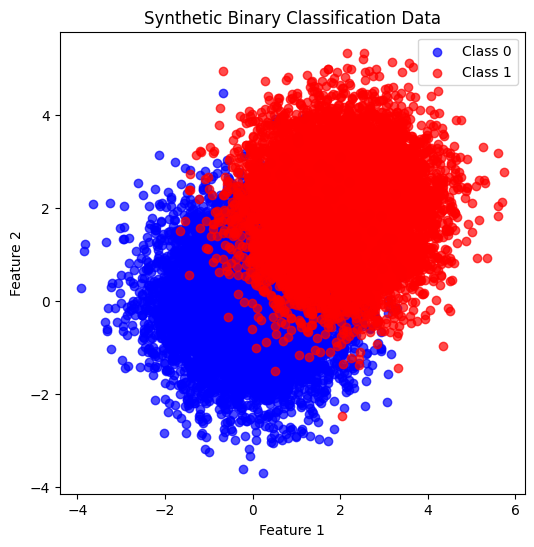

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(X[y.flatten()==0,1], X[y.flatten()==0,2], label='Class 0', color='blue', alpha=0.7)
plt.scatter(X[y.flatten()==1,1], X[y.flatten()==1,2], label='Class 1', color='red', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic Binary Classification Data')
plt.legend()
plt.show()


## 3. Logistic Regression: Loss and Gradients
We define:

- **Sigmoid function:** maps linear combination to probability.
- **Binary cross-entropy loss:** measures prediction error.
- **Gradient and Hessian:** required for GD and Newton-Raphson.


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps)
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

def compute_gradient(X, y, w):
    y_pred = sigmoid(X @ w)
    return X.T @ (y_pred - y) / X.shape[0]

def compute_hessian(X, w):
    y_pred = sigmoid(X @ w)
    S = np.diag((y_pred*(1-y_pred)).flatten())
    return X.T @ S @ X / X.shape[0]


## 4. Optimization Algorithms

We implement four algorithms **from scratch**:

1. **Gradient Descent:** full-batch gradient update.
2. **Stochastic Gradient Descent (SGD):** updates on one sample at a time.
3. **Newton-Raphson:** uses second-order derivative (Hessian) for faster convergence.
4. **Adam:** combines momentum and adaptive learning rates.


In [ ]:
import time  # for measuring execution time

# -----------------------------
# 4.1 Gradient Descent
# -----------------------------
def gradient_descent(X, y, lr=0.1, epochs=100):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    start_time = time.time()  # start timer
    for i in range(epochs):
        grad = compute_gradient(X, y, w)
        w -= lr * grad
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()  # end timer
    elapsed = end_time - start_time
    return w, loss_history, elapsed

# -----------------------------
# 4.2 Stochastic Gradient Descent
# -----------------------------
def stochastic_gradient_descent(X, y, lr=0.1, epochs=100):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    n_samples = X.shape[0]
    start_time = time.time()
    for i in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled, y_shuffled = X[indices], y[indices]
        for j in range(n_samples):
            x_i = X_shuffled[j].reshape(1,-1)
            y_i = y_shuffled[j].reshape(-1,1)
            w -= lr * compute_gradient(x_i, y_i, w)
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()
    elapsed = end_time - start_time
    return w, loss_history, elapsed

# -----------------------------
# 4.3 Newton-Raphson
# -----------------------------
def newton_raphson(X, y, epochs=10):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    start_time = time.time()
    for i in range(epochs):
        grad = compute_gradient(X, y, w)
        H = compute_hessian(X, w)
        try:
            w -= np.linalg.inv(H) @ grad
        except np.linalg.LinAlgError:
            w -= grad
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()
    elapsed = end_time - start_time
    return w, loss_history, elapsed

# -----------------------------
# 4.4 Adam Optimizer
# -----------------------------
def adam(X, y, lr=0.1, epochs=100, beta1=0.9, beta2=0.999, eps=1e-8):
    w = np.zeros((X.shape[1],1))
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    loss_history = []
    start_time = time.time()
    for t in range(1, epochs+1):
        grad = compute_gradient(X, y, w)
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()
    elapsed = end_time - start_time
    return w, loss_history, elapsed

## 5. Train All Algorithms and Compare Convergence
We will train all optimizers and plot the loss over epochs.


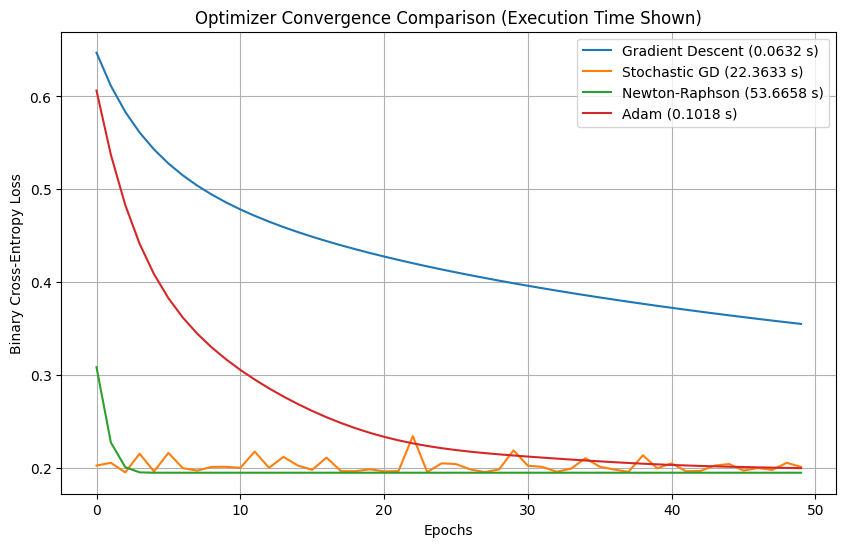

In [ ]:
import time

# -----------------------------
# Train and record loss + time
# -----------------------------
epochs = 50

w_gd, loss_gd, time_gd = gradient_descent(X, y, lr=0.1, epochs=epochs)
w_sgd, loss_sgd, time_sgd = stochastic_gradient_descent(X, y, lr=0.1, epochs=epochs)
w_nr, loss_nr, time_nr = newton_raphson(X, y, epochs=epochs)
w_adam, loss_adam, time_adam = adam(X, y, lr=0.1, epochs=epochs)

# -----------------------------
# Plot convergence with time info
# -----------------------------
plt.figure(figsize=(10,6))

plt.plot(loss_gd, label=f'Gradient Descent ({time_gd:.4f} s)')
plt.plot(loss_sgd, label=f'Stochastic GD ({time_sgd:.4f} s)')
plt.plot(loss_nr, label=f'Newton-Raphson ({time_nr:.4f} s)')
plt.plot(loss_adam, label=f'Adam ({time_adam:.4f} s)')

plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Optimizer Convergence Comparison (Execution Time Shown)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Evaluate Accuracy

Finally, we check the **prediction accuracy** of each trained model on the training dataset.


In [ ]:
def predict(X, w):
    return (sigmoid(X @ w) >= 0.5).astype(int)

def accuracy(X, y, w):
    return np.mean(predict(X, w) == y)

print("Accuracy GD:", accuracy(X, y, w_gd))
print("Accuracy SGD:", accuracy(X, y, w_sgd))
print("Accuracy Newton-Raphson:", accuracy(X, y, w_nr))
print("Accuracy Adam:", accuracy(X, y, w_adam))


Accuracy GD: 0.8598
Accuracy SGD: 0.9173
Accuracy Newton-Raphson: 0.92055
Accuracy Adam: 0.9195


## 7. Decision Boundaries for All Optimizers in a Single Figure

In [ ]:
# -----------------------------
# Function to plot decision boundary (same as before)
# -----------------------------
def plot_decision_boundary_multi(X, y, ws, labels, title='Decision Boundaries'):
    """
    X: input features with bias
    y: labels
    ws: list of trained weight vectors
    labels: corresponding labels for each weights vector
    """
    x_min, x_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    y_min, y_max = X[:,2].min() - 0.5, X[:,2].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    plt.figure(figsize=(8,8))

    # plot original data points
    plt.scatter(X[y.flatten()==0,1], X[y.flatten()==0,2], color='blue', label='Class 0', alpha=0.3)
    plt.scatter(X[y.flatten()==1,1], X[y.flatten()==1,2], color='red', label='Class 1', alpha=0.3)

    # different colors for each optimizer
    colors = ['green', 'orange', 'purple', 'cyan']

    for i, w in enumerate(ws):
        grid = np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]
        Z = sigmoid(grid @ w)
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0.5], colors=[colors[i]], linewidths=2, linestyles='--')
        plt.text(x_max-1.2, y_max-0.5-i*0.2, f'{labels[i]}', color=colors[i], fontsize=10)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.show()


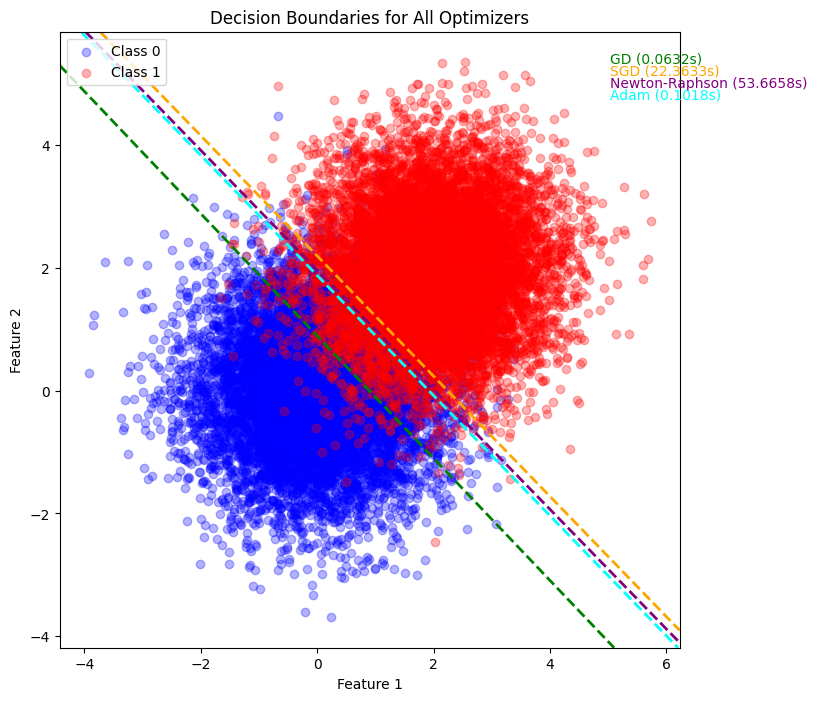

In [ ]:
# -----------------------------
# Combine all trained weights and labels
# -----------------------------
weights_list = [w_gd, w_sgd, w_nr, w_adam]
labels_list = [
    f'GD ({time_gd:.4f}s)',
    f'SGD ({time_sgd:.4f}s)',
    f'Newton-Raphson ({time_nr:.4f}s)',
    f'Adam ({time_adam:.4f}s)'
]

# -----------------------------
# Plot all decision boundaries in one figure
# -----------------------------
plot_decision_boundary_multi(X, y, weights_list, labels_list, title='Decision Boundaries for All Optimizers')
